In [1]:
import numpy as np
import pandas as pd
import torch

In [5]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [6]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [7]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [8]:
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from coral import DataSourceFactory

In [9]:
DEFAULT_SOURCE = DataSourceType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
symbol_indices_filename = f'ocean_symbol_idx_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'
res_filename = f'ocean_res_{today}.npy'

In [11]:
datasource_factory = DataSourceFactory(EnvironmentSecretService())
datasource_factory.register_rest_exchange(DEFAULT_SOURCE)

In [12]:
exchange = datasource_factory.create(DEFAULT_SOURCE, ProtocolType.REST)

symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

KeyboardInterrupt: 

In [31]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [32]:
symbols_df.head()

Symbol           Timestamp      Open      High       Low  \
0  10000000AIDOGEUSDT 2024-03-05 10:45:00  0.004816  0.004816  0.004807   
1  10000000AIDOGEUSDT 2024-03-05 11:00:00  0.004807  0.006305  0.004617   
2  10000000AIDOGEUSDT 2024-03-05 11:15:00  0.006210  0.007224  0.005910   
3  10000000AIDOGEUSDT 2024-03-05 11:30:00  0.006182  0.006208  0.005710   
4  10000000AIDOGEUSDT 2024-03-05 11:45:00  0.005939  0.006073  0.005634   

      Close       Volume  
0  0.004807        400.0  
1  0.006210  719649408.0  
2  0.006182  743186304.0  
3  0.005939  321725888.0  
4  0.005765  209583600.0

In [34]:
def volume_features(df, period_14=14, period_20=20, period_30=30):
    df = df.copy()

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = df['Timestamp'].dt.date

    grouped = df.groupby(['Symbol', 'Date'])

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['True Range'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Previous Close']), abs(row['Low'] - row['Previous Close'])), axis=1)
    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Price Change'] = grouped['Close'].diff()
    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)
    df['VROC'] = df['Volume'].pct_change(period_14)
    df['HL'] = (df['High'] - df['Low']).replace(0, 1e-6)

    df['ADV'] = grouped['Volume'].transform('mean')
    df['IVR'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Turnover_Ratio'] = df['Volume'] / df['ADV'].replace(0, 1e-6)

    df['PVT'] = df['Close'].pct_change() * df['Volume']
    df['PVT'] = df.groupby('Symbol')['PVT'].cumsum()
    df['VMO'] = (df['Volume'] - df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).mean())) / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)

    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']
    df['Cum_Volume'] = grouped['Volume'].cumsum()
    df['Cum_Price_Volume'] = grouped['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e-6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()
    df['VWAP_STD'] = df.groupby('Symbol')['VWAP'].transform(lambda x: x.rolling(window=period_20).std())
    df['VWAP_UPPER'] = df['VWAP'] + (df['VWAP_STD'] * 2)
    df['VWAP_LOWER'] = df['VWAP'] - (df['VWAP_STD'] * 2)
    df['Vol_Adj_VWAP'] = df['VWAP'] * df['True Range']
    df['Alpha_Decay'] = df['Price Change'] / df['Volume'].shift(1)
    df['Alpha_Decay'] = df.groupby('Symbol')['Alpha_Decay'].transform(lambda x: x.rolling(window=period_14).mean())

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / df['HL']
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio'].replace(0, 1e-6)
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['OBV'] = (np.sign(df['Price Change']) * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['HL'] * df['Volume']).replace(0, 1e-6)
    df['A/D'] = grouped['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['VWMA'] = df.groupby('Symbol')['Typical Price'].transform(lambda x: (x * df['Volume']).rolling(window=period_20).sum() / df['Volume'].rolling(window=period_20).sum())
    df['LSVS'] = (df['Volume'] / df['Volume'].rolling(window=period_30).mean()) / df['True Range']

    df['Effective_Spread'] = df['HL'] / df['VWAP']
    df['Relative_Spread'] = df['Effective_Spread'] / df['Close'].replace(0, 1e-6)
    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = grouped['Amihud_Illiquidity'].transform('mean')
    df['Amihud_Lambda'] = df['Amihud_Illiquidity'] / df['True Range'].replace(0, 1e-6)

    df['Liquidity_Gap'] = df['HL'] / df['Close'].replace(0, 1e-6)
    df['Liquidity_Hole'] = df['HL'] / df['Volume'].replace(0, 1e-6)
    df['Liquidity_Hole_Rolling'] = df.groupby('Symbol')['Liquidity_Hole'].transform(lambda x: x.rolling(window=period_20).std())
    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e-6)
    df['Liquidity_Shock'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).max()).replace(0, 1e-6)
    df['Liquidity_Shock_Volatility'] = df['True Range'] * df['Liquidity_Shock']
    df['Liquidity_Density'] = df['Volume'] / df['HL']
    df['LAV'] = df['True Range'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)

    df['II'] = (2 * df['Close'] - df['HL']) / (df['HL'] * df['Volume']).replace(0, 1e-6)

    df['High_Low_Range'] = df['HL'] / df['Previous Close'].replace(0, 1e-6)
    df['Intraday_Volatility'] = df.groupby('Symbol')['High_Low_Range'].transform(lambda x: x.rolling(window=period_14).std())
    df['Price_Reversal'] = (df['Close'] - df['Low']) / df['HL']

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] < 0, 0)

    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e-6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e-6)
    df['NMP'] = df['Buy Volume'] - df['Sell Volume']
    df['MPR'] = df['NMP'].diff() / df['Volume'].replace(0, 1e-6)
    df['CVD'] = df.groupby('Symbol')['NMP'].cumsum()
    df['OFI'] = df['NMP'] / df['Volume'].replace(0, 1e-6)
    df['COFI'] = df.groupby('Symbol')['OFI'].transform(lambda x: x.rolling(window=period_14).sum())
    df['VPI'] = df['OFI'] * df['Price Change']
    df['Buy_Volume_Imbalance'] = df.groupby('Symbol')['Buy Volume'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Sell_Volume_Imbalance'] = df.groupby('Symbol')['Sell Volume'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Imbalance_Ratio'] = df['Buy_Volume_Imbalance'] / df['Sell_Volume_Imbalance'].replace(0, 1e-6)
    df['Volume_IMB'] = df['Buy_Volume_Imbalance'] - df['Sell_Volume_Imbalance']
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e-6)
    df['Flow_Imbalance_TW'] = df['Flow_R'].ewm(span=period_14, adjust=False).mean()

    df['Volume_Adjusted'] = df['Volume'].replace(0, 1e-6)
    df['Volume_Sum'] = df.groupby('Symbol')['Volume_Adjusted'].transform('sum')
    df['Volume_Entropy'] = -(df['Volume_Adjusted'] / df['Volume_Sum']) * np.log(df['Volume_Adjusted'] / df['Volume_Sum'])
    df['Volume_Entropy'] = df.groupby('Symbol')['Volume_Entropy'].cumsum()

    df['Volume_Skewness'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).skew()).replace(0, 1e-6)
    df['Volume_Kurtosis'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).kurt()).replace(0, 1e-6)

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Surge_Intensity'] = (df['RVOL'] - 1) / df.groupby('Symbol')['RVOL'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)
    df['Volume_Rank'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).apply(lambda y: pd.Series(y).rank(pct=True).iloc[-1]))

    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / df['HL']).ewm(span=period_14, adjust=False).mean().replace(0, 1e-6)

    df['Market_Impact_Cost'] = (df['Close'] - df['VWAP']) * df['Volume']
    df['Price_Impact_Asymmetry'] = (df['Close'] - df['VWAP']) / df['True Range'].replace(0, 1e-6)

    df['Intraday_Volume_Dispersion'] = grouped['Volume'].transform(lambda x: x.rolling(window=period_30).std())
    df['Intraday_Price_Dispersion'] = grouped['Close'].transform(lambda x: x.rolling(window=period_30).std())

    df['Abnormal_Return'] = df['Price Change'] - df.groupby('Symbol')['Price Change'].transform(lambda x: x.rolling(window=period_14).mean())
    df['CAR'] = df.groupby('Symbol')['Abnormal_Return'].cumsum()

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    drop_columns = [
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume', 'Buy_Volume_Imbalance', 'Effective_Spread',
        'Buy Volume', 'Sell Volume', 'Midpoint Move', 'Price Change', 'Positive Money Flow', 'Sell_Volume_Imbalance', 'OFI', 'HL', 'Abnormal_Return',
        'Negative Money Flow', 'Previous Close', 'Raw Money Flow', 'Volume_Adjusted', 'Volume_Sum', 'VWAP_STD', 'High_Low_Range',
    ]
    df.drop(columns=drop_columns, inplace=True)

    return df

In [35]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

Epoch [21/100], Train Loss: 0.47554882
Saved improved snapshot: snapshots/AutoEncoder_epoch_21_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_19_improved.pth
Removed old improved snapshot: snapshots/AutoEncoder_epoch_20_improved.pth


In [9]:
volume_df = pd.read_csv(volume_df_filename)

In [10]:
all_symbols = volume_df['Symbol'].values

symbols = np.unique(all_symbols)
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [10]:
volume = ['ADV', 'IVR', 'RVOL', 'Volume_IMB', 'CVD', 'VROC', 'Volume_Entropy', 'NMP', 'PVT', 'VMO', 'Volume_Skewness', 'Volume_Kurtosis', 'Surge_Intensity', 'Turnover_Ratio', 'Volume_Rank', 'Imbalance_Ratio', 'Intraday_Volume_Dispersion', 'COFI']
price_volume = ['VWAP', 'VWAP_MOM', 'VWAP_UPPER', 'VWAP_LOWER', 'MFI', 'Flow_R', 'Flow_Imbalance_TW', 'KVO', 'EOM', 'VWMA', 'Price_Reversal', 'Vol_Adj_VWAP', 'Intraday_Price_Dispersion', 'VPI', 'Alpha_Decay', 'CAR']
liquidity = ['Amihud_Illiquidity', 'Amihud_Lambda', 'LII', 'Liquidity_Hole', 'Liquidity_Hole_Rolling', 'II', 'Liquidity_Ratio', 'Liquidity_Shock', 'Liquidity_Shock_Volatility', 'LAV', 'LSVS', 'Intraday_Volatility', 'Relative_Spread', 'Liquidity_Gap', 'Liquidity_Density']
accumulation_distribution = ['A/D', 'OBV', 'CMF']
market = ['Market_Impact_Cost', 'Price_Impact_Asymmetry']

features = volume + price_volume + liquidity + accumulation_distribution + market
n_features = len(features)

print("N Features: ", n_features)

N Features:  54


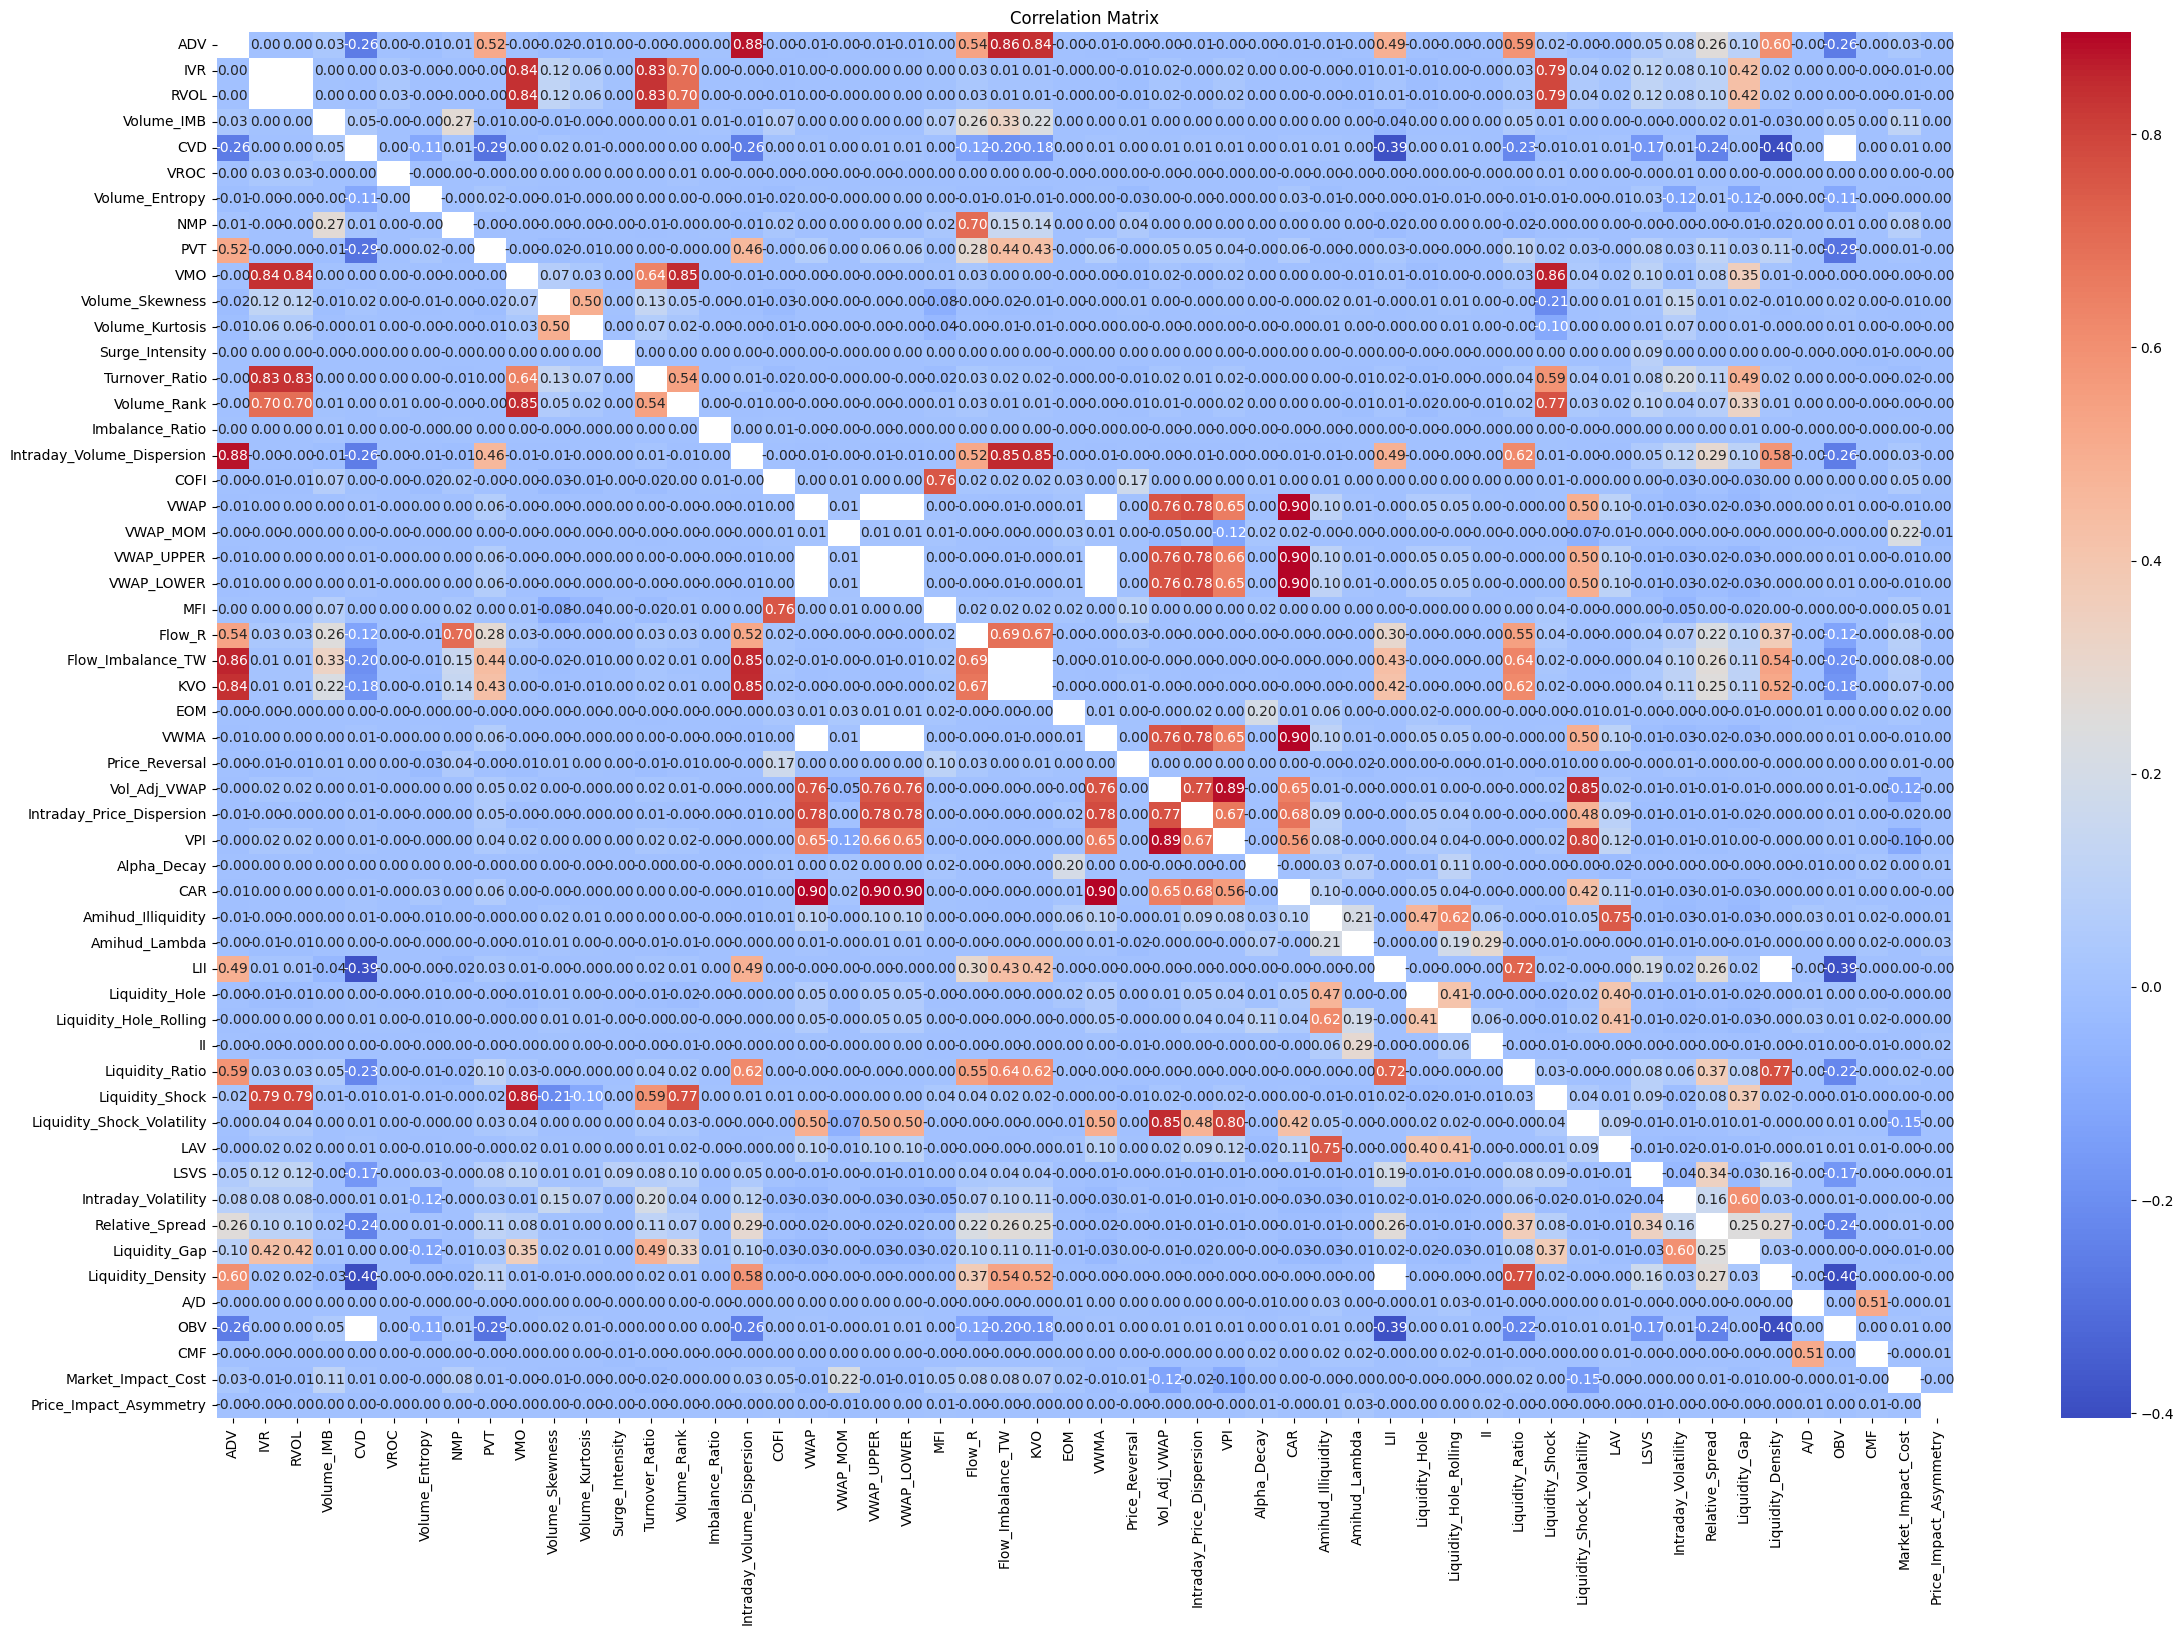

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_matrix(df, threshold=0.9):
    plt.figure(figsize=(28, 18))
    corr = df.corr()
    mask = np.abs(corr) > threshold
    sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(volume_df[features])

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def remove_collinearity(df, corr_threshold=0.85, threshold=10):
    df = df.copy()

    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    collinear_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
    df.drop(columns=collinear_features, inplace=True)

    X = df.fillna(0)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    high_vif_features = vif_data[vif_data['VIF'] > threshold]['feature'].tolist()
    df.drop(columns=high_vif_features, inplace=True)

    return df

reduced_features_df = remove_collinearity(volume_df[features])
reduced_features = reduced_features_df.columns

reduced_features_df['Symbol'] = all_symbols

In [41]:
print(f"Reduced: {abs(len(features) - len(reduced_features))} features")
print(list(set(features) - set(reduced_features)))

Reduced: 10 features
['VWAP_UPPER', 'VWMA', 'Flow_Imbalance_TW', 'RVOL', 'OBV', 'Flow_R', 'Liquidity_Density', 'Vol_Adj_VWAP', 'VWAP_LOWER', 'KVO']


In [42]:
reduced_features_df.head()

ADV  IVR  Volume_IMB          CVD  VROC  Volume_Entropy  \
0  213498380.0  NaN         NaN          0.0   NaN    3.507124e-08   
1  213498380.0  NaN         NaN  719649400.0   NaN    1.804164e-02   
2  213498380.0  NaN         NaN  -23536896.0   NaN    3.656934e-02   
3  213498380.0  NaN         NaN -345262800.0   NaN    4.576091e-02   
4  213498380.0  NaN         NaN -554846400.0   NaN    5.213907e-02   

           NMP          PVT  VMO  Volume_Skewness  ...  LAV  LSVS  \
0          0.0          NaN  NaN              NaN  ...  NaN   NaN   
1  719649400.0  210041150.0  NaN              NaN  ...  NaN   NaN   
2 -743186300.0  206690270.0  NaN              NaN  ...  NaN   NaN   
3 -321725900.0  194043970.0  NaN              NaN  ...  NaN   NaN   
4 -209583600.0  187903630.0  NaN              NaN  ...  NaN   NaN   

   Intraday_Volatility  Relative_Spread  Liquidity_Gap     A/D  CMF  \
0                  NaN         0.389238       0.001872 -0.0025  NaN   
1                  NaN        47.598587       0.271820 -0.0025  NaN   
2                  NaN        34.956303       0.212553 -0.0025  NaN   
3                  NaN        13.842944       0.083852 -0.0025  NaN   
4                  NaN        12.622352       0.076149 -0.0025  NaN   

   Market_Impact_Cost  Price_Impact_Asymmetry              Symbol  
0             -0.0012               -0.333368  10000000AIDOGEUSDT  
1         359345.2200                0.295814  10000000AIDOGEUSDT  
2          75416.2500                0.077227  10000000AIDOGEUSDT  
3         -38096.6800               -0.237778  10000000AIDOGEUSDT  
4         -56143.6520               -0.610210  10000000AIDOGEUSDT  

[5 rows x 45 columns]

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

segment_length = 512
overlap = 128

def segment_by_symbol_and_save(df, features, segment_length, overlap):
    symbols = df['Symbol'].unique()

    print("NaN values before imputation:\n", df.isna().sum())
    imputer = SimpleImputer(strategy='constant', fill_value=0.0)
    df[features] = imputer.fit_transform(df[features])

    symbol_sequences = [df[df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
    print("Symbol seq: ", len(symbol_sequences))

    def segment_sequence(sequence, segment_length, overlap, pad_left=False):
        segments = []
        step = segment_length - overlap

        for start in range(0, len(sequence), step):
            end = min(start + segment_length, len(sequence))
            segment = sequence[start:end]

            if len(segment) < segment_length:
                pad_width = segment_length - len(segment)

                if pad_left:
                    segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
                else:
                    segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

            segments.append(segment)

        return segments

    def segment_all_sequences(sequences, segment_length, overlap):
        segmented_sequences = []
        segment_symbol_indices = []
        for symbol_idx, seq in enumerate(sequences):
            segments = segment_sequence(seq, segment_length, overlap)
            segmented_sequences.extend(segments)
            segment_symbol_indices.extend([symbol_idx] * len(segments))
        return segmented_sequences, segment_symbol_indices

    segmented_sequences, segment_symbol_indices = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
    segmented_sequences = np.array(segmented_sequences)

    n_segments, segment_length, n_features = segmented_sequences.shape

    scaler = StandardScaler()
    segmented_sequences = segmented_sequences.reshape(-1, n_features)
    normalized_segments = scaler.fit_transform(segmented_sequences)
    normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

    print("Shape of normalized features:", normalized_segments.shape)
    print("Number of symbols:", n_symbols)

    np.save(features_filename, normalized_segments)
    np.save(symbol_indices_filename, segment_symbol_indices)

segment_by_symbol_and_save(reduced_features_df, reduced_features, segment_length=segment_length, overlap=overlap)

NaN values before imputation:
 ADV                                 0
IVR                              7809
Volume_IMB                       5343
CVD                                 0
VROC                             9955
Volume_Entropy                      0
NMP                                 0
PVT                                 1
VMO                              5343
Volume_Skewness                  5343
Volume_Kurtosis                  5343
Surge_Intensity                 13152
Turnover_Ratio                      0
Volume_Rank                      7809
Imbalance_Ratio                  5343
Intraday_Volume_Dispersion    2437542
COFI                             5343
VWAP                                0
VWAP_MOM                          411
MFI                              5343
EOM                              5344
Price_Reversal                      0
Intraday_Price_Dispersion     2437542
VPI                             84069
Alpha_Decay                   1233282
CAR                

In [11]:
from notebooks.pipelines import ocean_train

epochs = 100
latent_dim = 32
lr = 1e-4

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
No snapshots found, starting from scratch.
Start training with epochs 100
Epoch [1/100], Train Loss: 1.13364714
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth


KeyboardInterrupt: 

In [46]:
def create_emb(symbols):
    embeddings = np.load(emb_filename)
    segment_symbol_indices = np.load(symbol_indices_filename)

    print("Embedding shape:", embeddings.shape)
    print("Symbol Idx shape:", segment_symbol_indices.shape)

    symbol_embeddings_dict = {symbol: [] for symbol in symbols}

    for i, symbol_idx in enumerate(segment_symbol_indices):
        symbol = symbols[symbol_idx]
        symbol_embeddings_dict[symbol].append(embeddings[i])

    df = pd.DataFrame({
        'symbol': symbol_embeddings_dict.keys(),
        'embeddings': symbol_embeddings_dict.values()
    })

    return df

res_df = create_emb(symbols)

print("DF shape:", res_df.shape)
print("\n", res_df.head())

Embedding shape: (20992, 32)
Symbol Idx shape: (20992,)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[0.27525762, 0.24636692, 0.18916178, 0.083850...
1  1000000BABYDOGEUSDT  [[0.16834271, 0.43398744, 0.259104, 0.17891097...
2       1000000MOGUSDT  [[0.2303695, 0.14574815, 0.029809544, 0.407170...
3    1000000PEIPEIUSDT  [[0.31700397, 0.35877463, 0.16851902, 0.106250...
4         10000COQUSDT  [[0.14545023, 0.41587383, 0.13575043, 0.267780...


In [47]:
all_embeddings = np.vstack(res_df['embeddings'].values)
all_embeddings.shape

(20992, 32)

Sparsity: 0.00%
Mean: 0.05653611570596695
Std: 0.16749228537082672
[[1.0000001  0.6614278  0.6851622  ... 0.84230494 0.74971974 0.82481414]
 [0.6614278  0.9999999  0.81347257 ... 0.7461663  0.79219115 0.72363085]
 [0.6851622  0.81347257 1.0000001  ... 0.7342868  0.8281353  0.71261907]
 ...
 [0.84230494 0.7461663  0.7342868  ... 1.         0.83175886 0.8591487 ]
 [0.74971974 0.79219115 0.8281353  ... 0.83175886 1.0000001  0.8534802 ]
 [0.82481414 0.72363085 0.71261907 ... 0.8591487  0.8534802  1.        ]]


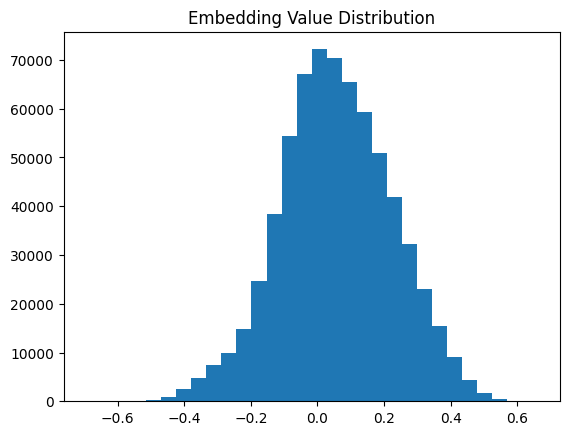

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

print(f"Sparsity: {(np.sum(all_embeddings == 0) / all_embeddings.size) * 100:.2f}%")
print(f"Mean: {np.mean(all_embeddings)}")
print(f"Std: {np.std(all_embeddings)}")

print(cosine_similarity(all_embeddings))

plt.hist(all_embeddings.flatten(), bins=30)
plt.title("Embedding Value Distribution")
plt.show()

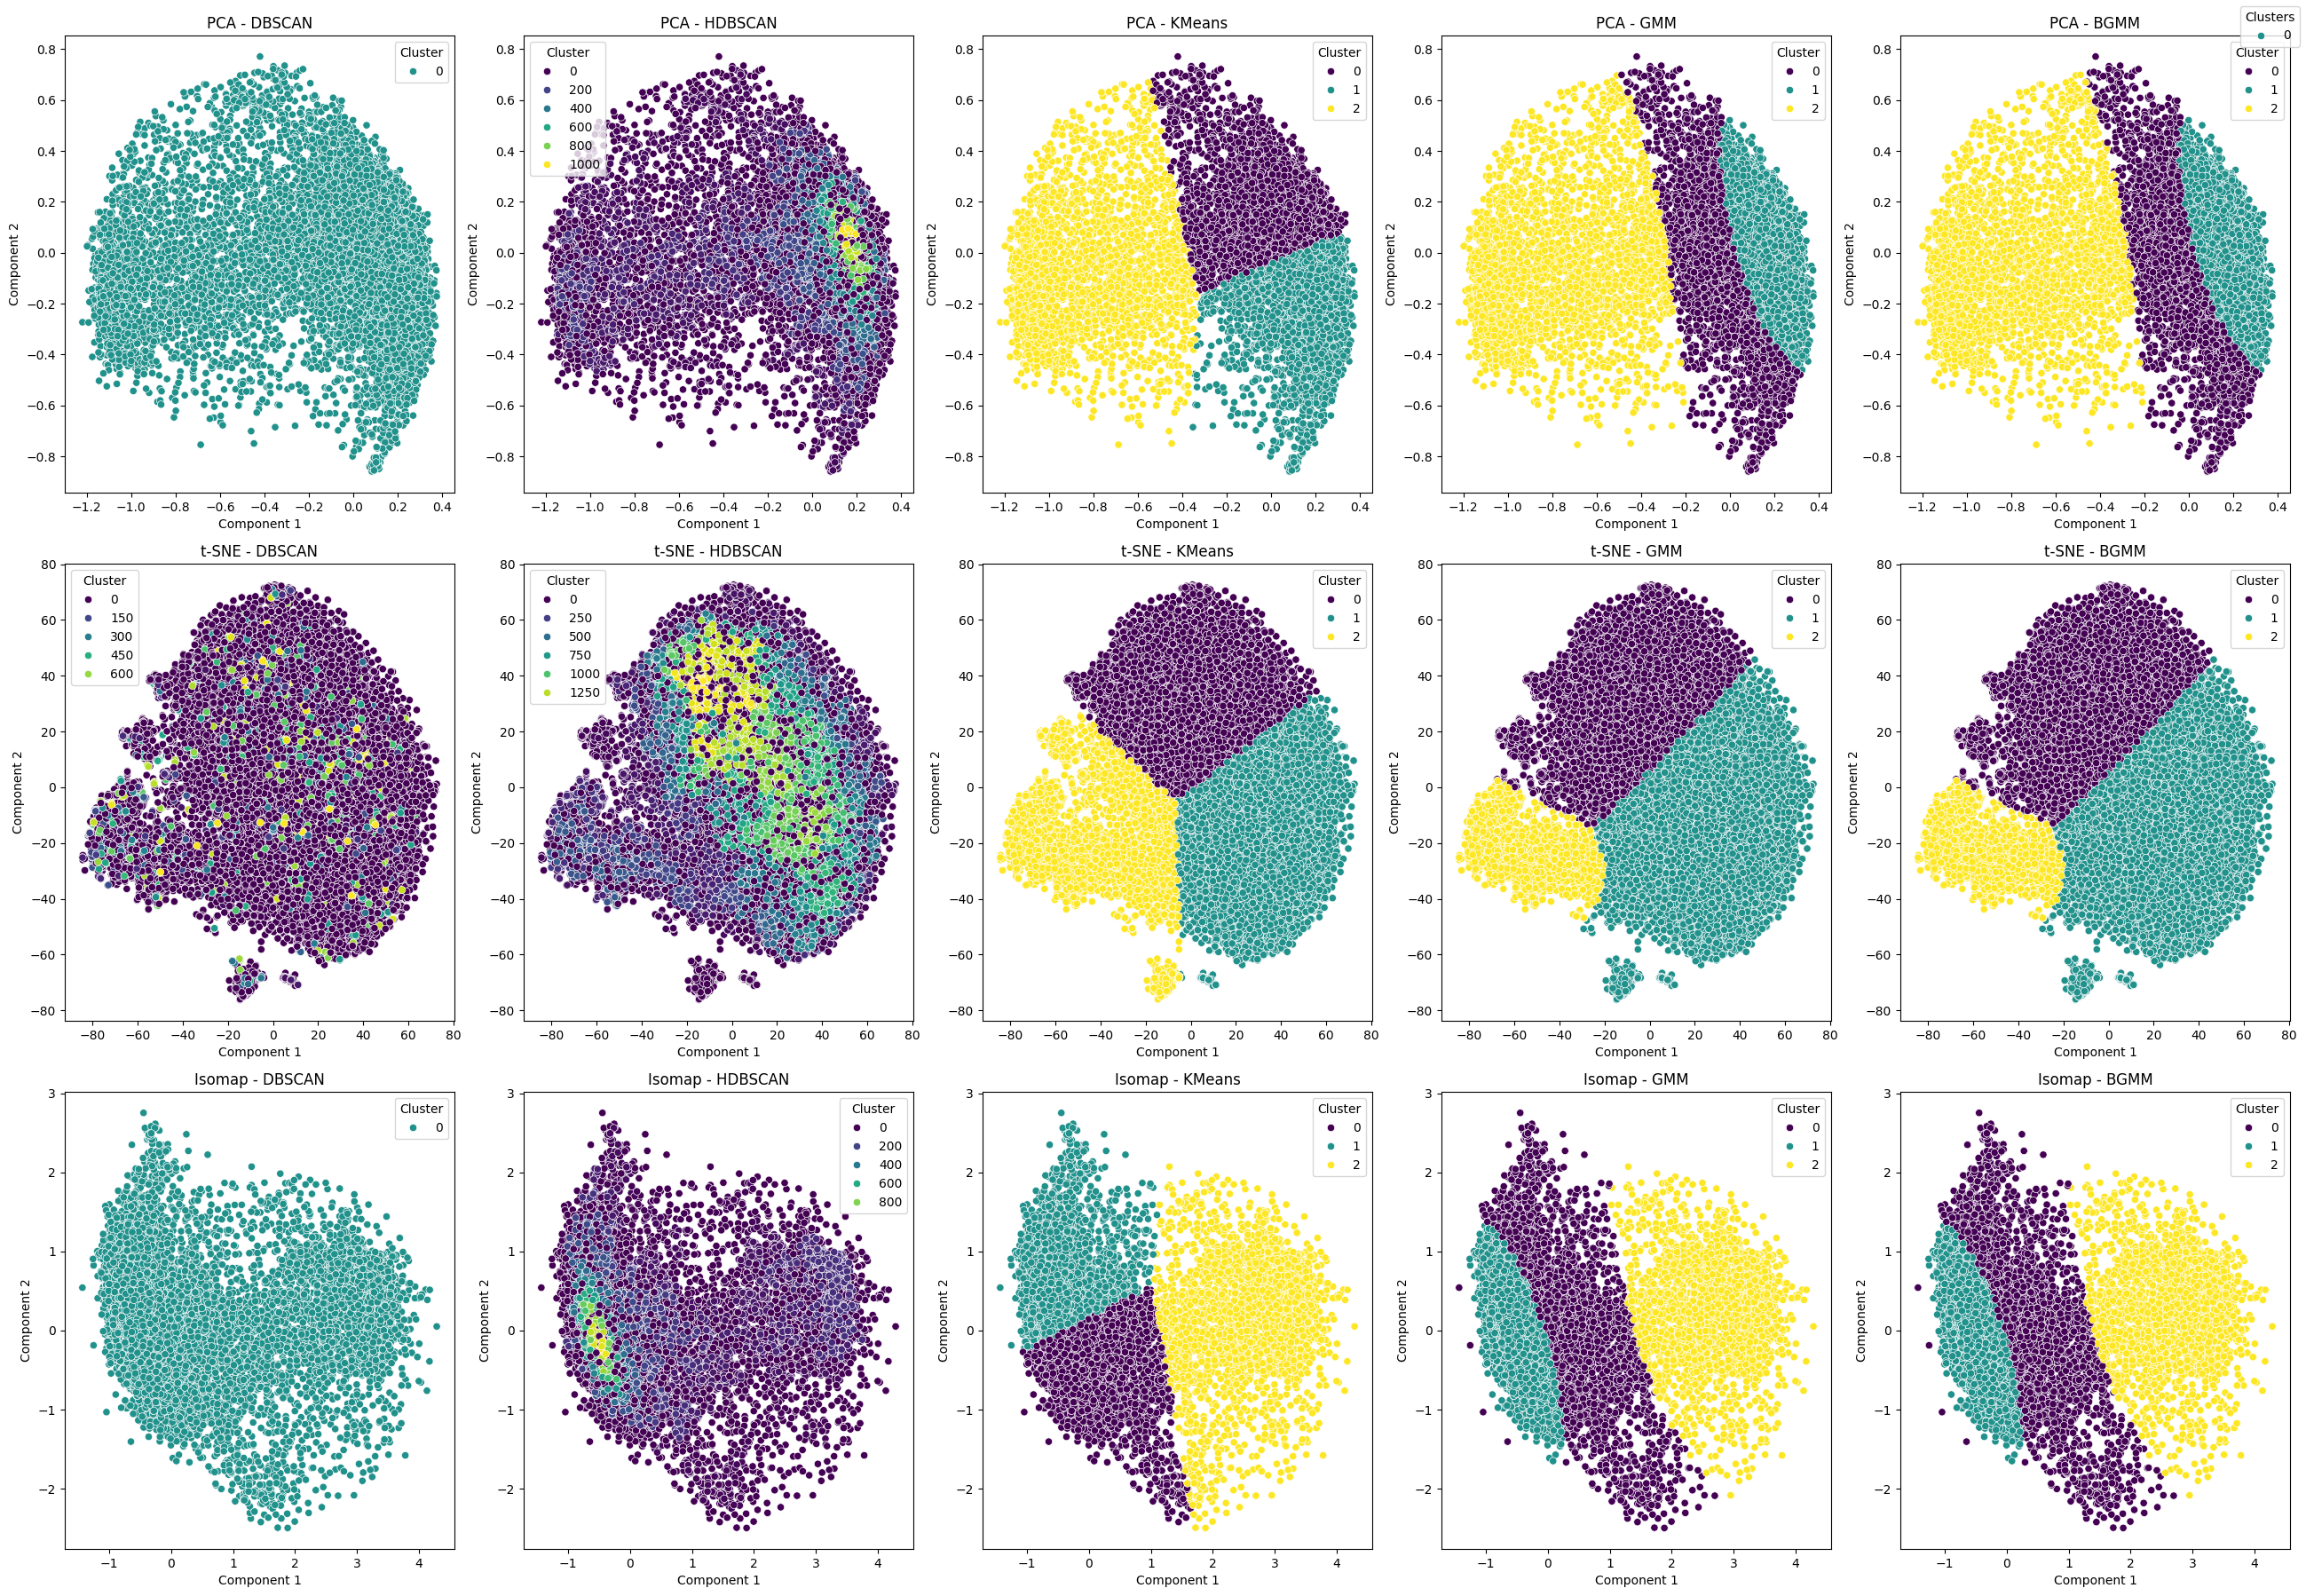

In [53]:
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

n_clusters = 3
n_components = 2

def visualize_clustering(all_embeddings, n_clusters=3, n_components=2, random_state=1337):
    clustering_methods = {
        "DBSCAN": DBSCAN(),
        "HDBSCAN": HDBSCAN(),
        "KMeans": KMeans(n_clusters=n_clusters, random_state=random_state),
        "GMM": GaussianMixture(n_components=n_clusters, random_state=random_state, tol=1e-6, init_params='k-means++', max_iter=1800),
        "BGMM": BayesianGaussianMixture(n_components=n_clusters, random_state=random_state, tol=1e-6, init_params='k-means++', max_iter=1800)
    }

    dimensionality_methods = {
        "PCA": PCA(n_components=n_components, random_state=random_state),
        "t-SNE": TSNE(n_components=n_components, random_state=random_state),
        "Isomap": Isomap(n_components=n_components),
        # "MDS": MDS(n_components=n_components),
        # "Factor Analysis": FactorAnalysis(n_components=n_components),
    }

    fig, axes = plt.subplots(len(dimensionality_methods), len(clustering_methods), figsize=(26, 18))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (dim_name, dim_method) in enumerate(dimensionality_methods.items()):
        reduced_embeddings = dim_method.fit_transform(all_embeddings)

        for j, (cluster_name, cluster_method) in enumerate(clustering_methods.items()):
            cluster_labels = cluster_method.fit_predict(reduced_embeddings)

            df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
            df['Cluster'] = cluster_labels

            sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', ax=axes[i, j], legend='auto')
            axes[i, j].set_title(f'{dim_name} - {cluster_name}')
            axes[i, j].set_xlabel('Component 1')
            axes[i, j].set_ylabel('Component 2')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Clusters', loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_clustering(all_embeddings, n_clusters=n_clusters, n_components=n_components, random_state=seed)

In [54]:

def adjust_embedding_length(emb, target_length):
    emb = np.array(emb)

    if len(emb) < target_length:
        pad_width = target_length - len(emb)
        return np.pad(emb, (0, pad_width), 'constant')

    return emb[:target_length]

def flat_embeddings(df):
    df = df.copy()

    df['flat_embeddings'] = df['embeddings'].apply(lambda emb: [val for sublist in emb for val in sublist])

    embedding_lengths = df['flat_embeddings'].apply(len)
    max_length = embedding_lengths.max() if not embedding_lengths.empty else 0

    df['flat_embeddings'] = df['flat_embeddings'].apply(lambda emb: adjust_embedding_length(emb, max_length))

    return df

def reduce_embeddings(df, n_reduced=10):
    df = df.copy()

    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA(n_components=n_reduced)
    reduced_embeddings = pca.fit_transform(flat_embeddings)

    df['reduced_embeddings'] = list(reduced_embeddings)

    reduced_lengths = df['reduced_embeddings'].apply(len)
    reduced_uniq_lengths = reduced_lengths.value_counts()

    print("Reduced embedding lengths and counts:")
    print(reduced_uniq_lengths)

    return df

def optimal_n_components(df, threshold=0.90):
    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA()
    pca.fit(flat_embeddings)

    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    n_components = np.argmax(cumulative_variance >= threshold) + 1
    return n_components

flat_emb_df = flat_embeddings(res_df)
n_reduced = optimal_n_components(flat_emb_df)
print(f"n_components: {n_reduced}")

reduce_emb_df = reduce_embeddings(flat_emb_df, n_reduced=n_reduced)

simularity_values = reduce_emb_df[['symbol', 'reduced_embeddings']].values
print('\n', simularity_values[0])

np.save(f"out/{res_filename}", simularity_values)

n_components: 246
Reduced embedding lengths and counts:
reduced_embeddings
246    411
Name: count, dtype: int64

 ['10000000AIDOGEUSDT'
 array([ 2.40893647e-01,  9.79822874e-01, -4.95341241e-01,  3.95909160e-01,
         2.64343232e-01, -8.38494241e-01, -5.57840824e-01,  2.18520790e-01,
         3.74002695e-01, -2.15410113e-01,  3.03014703e-02, -1.33890301e-01,
        -7.96798706e-01,  5.27785778e-01,  4.14888203e-01, -2.05136210e-01,
         5.14961123e-01, -8.65930140e-01,  3.47933739e-01,  5.45413554e-01,
        -4.28898245e-01, -2.84994513e-01, -1.13672666e-01,  1.82381064e-01,
         2.19608128e-01,  6.07989021e-02, -4.36820805e-01, -3.58446062e-01,
         5.14244795e-01,  6.75119996e-01,  3.50074649e-01, -8.62758532e-02,
        -3.15730065e-01,  7.20986068e-01,  1.27622306e-01,  7.04281181e-02,
        -2.86265939e-01, -1.31210923e-01, -1.30590824e-02, -1.65719002e-01,
         2.97009051e-01, -4.63889867e-01,  3.40039670e-01, -5.52191615e-01,
         2.13185057e-01,  1.

In [55]:
from ocean import SIM

max_level = 8
max_neighbors = 40
ef_construction = 500
ef_search = 50

gsim = SIM(
    max_level=max_level,
    max_neighbors=max_neighbors,
    ef_construction=ef_construction,
    ef_search=ef_search
)

embs = np.load(f"out/{res_filename}", allow_pickle=True)

for symbol, emb in embs:
    gsim.insert(emb, symbol)

gsim.perform_clustering()

In [56]:
from core.models.cap import CapType

symbol = 'SOLUSDT'
val = reduce_emb_df[reduce_emb_df['symbol'] == symbol]['reduced_embeddings'].values
query = val[0]

print(f"Symbol: {symbol}")

neighbors = gsim.search(query, 8)
n_neighbors = len(neighbors)

print(f"Found {n_neighbors} nearest neighbors for the query.")

for i, neighbor in enumerate(neighbors):
    dist, node = neighbor
    print(f"{i} neighbor Symbol: {node.meta['symbol']}")

simular_symbols = gsim.find_similar_symbols(symbol, 4)
n_symbols = len(simular_symbols)

print(f"Found {n_symbols} simular symbols")

for symbol in simular_symbols:
    print(f"Symbol: {symbol}")

cap = CapType.A
cap_symbols = gsim.find_similar_by_cap(cap, top_k=18)
n_symbols = len(cap_symbols)

print(f"Found {n_symbols} symbols by: {cap.name}")

for symbol in cap_symbols:
    print(f"Symbol: {symbol}")

Symbol: SOLUSDT
Found 8 nearest neighbors for the query.
0 neighbor Symbol: SOLUSDT
1 neighbor Symbol: SNXUSDT
2 neighbor Symbol: ZILUSDT
3 neighbor Symbol: ZENUSDT
4 neighbor Symbol: RADUSDT
5 neighbor Symbol: TUSDT
6 neighbor Symbol: DASHUSDT
7 neighbor Symbol: ZECUSDT
Found 4 simular symbols
Symbol: SNXUSDT
Symbol: ZILUSDT
Symbol: ZENUSDT
Symbol: RADUSDT
Found 18 symbols by: A
Symbol: LQTYUSDT
Symbol: AGIUSDT
Symbol: BTCUSDT
Symbol: 1000PEPEUSDT
Symbol: DRIFTUSDT
Symbol: BBUSDT
Symbol: BAKEUSDT
Symbol: SCAUSDT
Symbol: AGLDUSDT
Symbol: CHRUSDT
Symbol: RONUSDT
Symbol: ALTUSDT
Symbol: BLURUSDT
Symbol: ARKUSDT
Symbol: 10000000AIDOGEUSDT
Symbol: MERLUSDT
Symbol: BENDOGUSDT
Symbol: POWRUSDT
